In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pdSS

In [5]:
# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/maltem/work/python/git/diusst-master/src')

# Load DiuSST model
from diusst import Diusst


In [6]:
data_orig = xr.load_dataset('data/moce5_dataset.cdf', decode_timedelta=False)

In [7]:
# Foundation temperature
T_f = np.mean(np.array(data_orig['ftemp']))

# Key parameters
kappa = 1.34e-4          # Eddy diffusivity
mu = 2.85e-3             # Mixing coefficient
alpha = 3.52             # Attenuation coefficient
sigma = 0.8              # Surface suppressivity

# Options
diffu_profile = 'LIN'    # Diffusivity profile
CFL = 0.95               # CFL number for integration

# Domain
z_f = 10                 # Foundation depth
dz0 = 0.1                # Grid spacing at surface
ngrid = 40               # Number of vertical grid points

print('Foundation temperature: {:.2f} K'.format(T_f))

Foundation temperature: 298.19 K


In [8]:
model = Diusst(T_f=T_f, kappa=kappa, mu=mu, alpha=alpha, sigma=sigma,
                diffu_profile=diffu_profile, CFL=CFL, z_f=z_f, dz0=dz0, ngrid=ngrid)

In [9]:
data_intp, dtlist, idx = model.interpolate(data_orig)

Variable time-step interpolation at CFL = 0.95:
---> Interpolated dataset has 267598 time steps with average length 7.737 s.
---> Constant dt interpolation would require dt = 1.711 s --> 997981 steps.
---> Computation time will be reduced by 73.186 %.


In [10]:
data_intp.time[1:]


1           31635.76
2           31645.76
3           31655.76
4           31665.76
5           31675.76
             ...    
267593    1738781.20
267594    1738791.20
267595    1738801.20
267596    1738811.20
267597    1738821.20
Name: time, Length: 267597, dtype: float64

In [11]:
simu = model.simulate(data_intp)

100%|██████████| 267597/267597 [00:23<00:00, 11349.99it/s]


In [13]:
# Grid point closest to 3m depth
ref_level = int(20)

# Calculate temperature difference
simu_dsst = simu[0][:,0]-simu[0][:,ref_level]

print('Reference depth at which the SST difference is taken: {:.3f} m.'.format(simu[2][ref_level]))

Reference depth at which the SST difference is taken: -3.045 m.


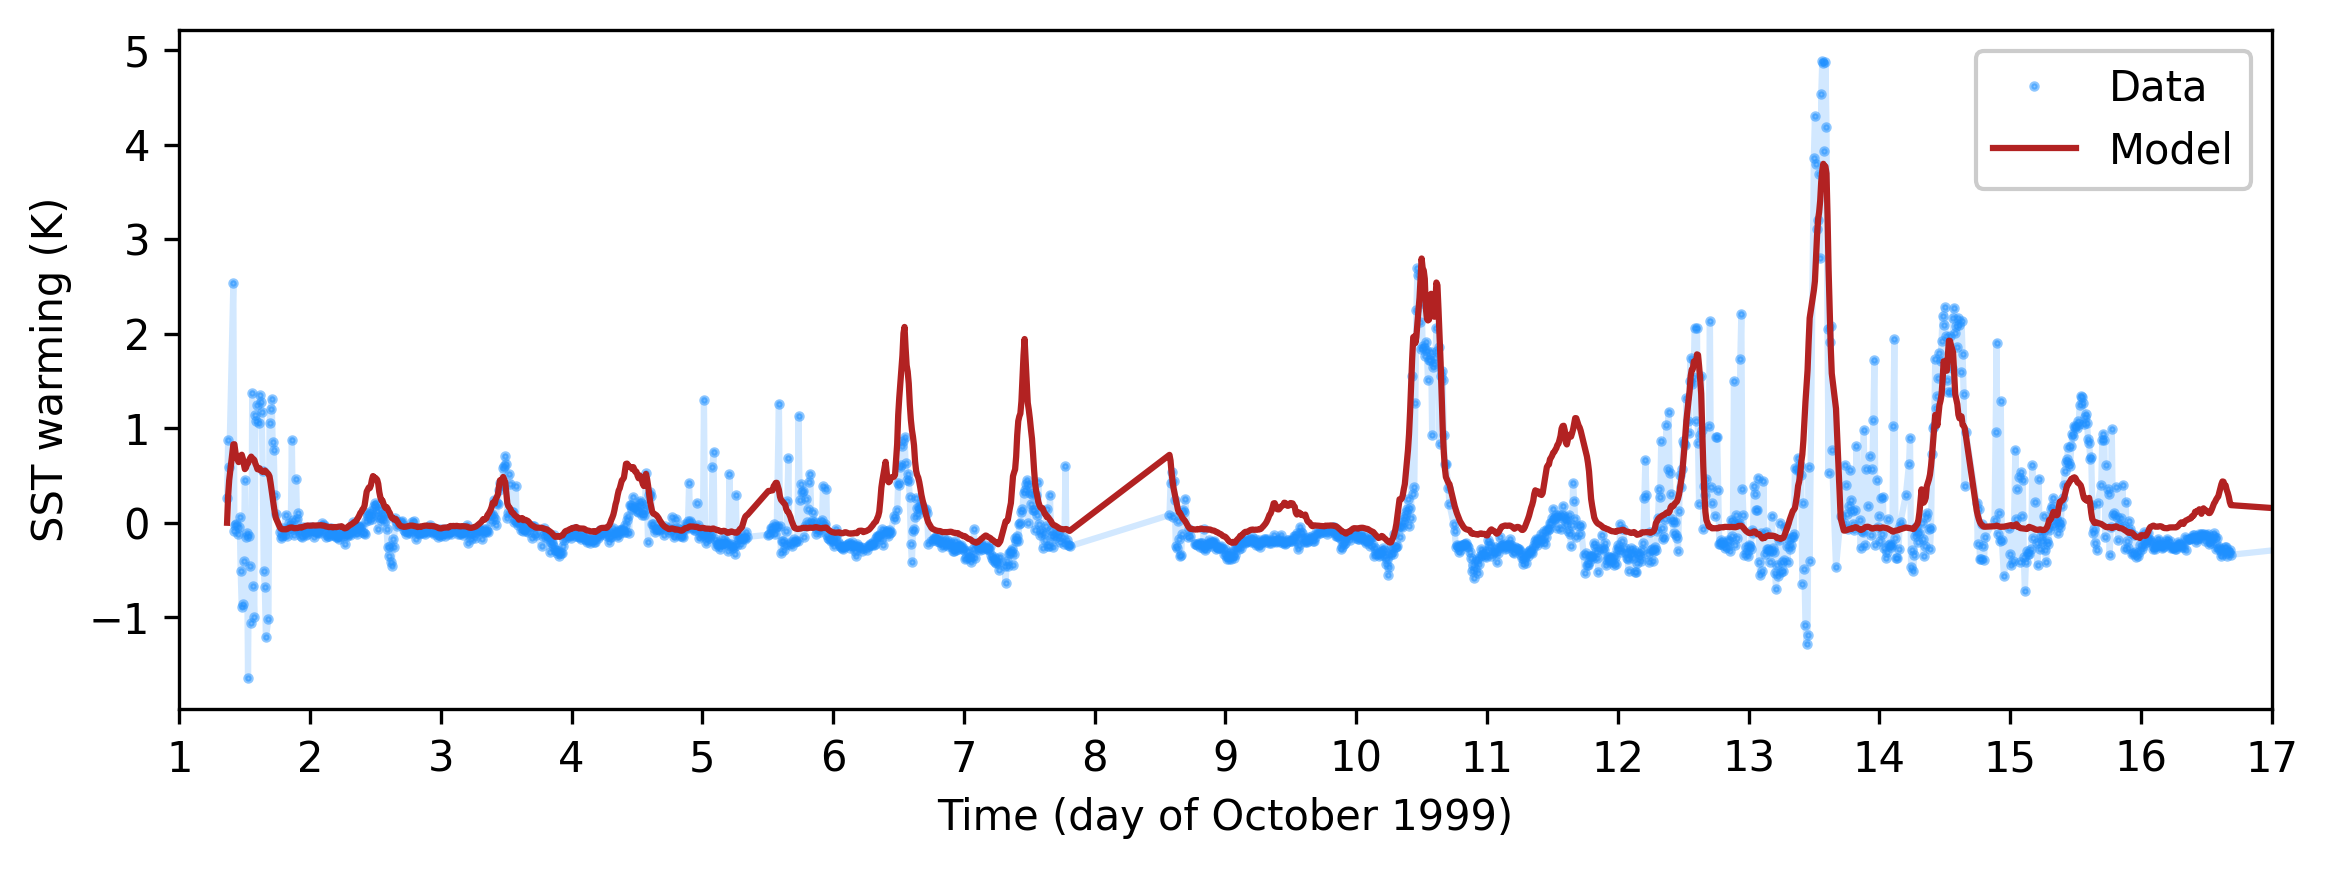

In [14]:
fig, ax = plt.subplots(dpi=300,figsize=(9,3))

ax.plot(data_orig['time_day'],data_orig['dsst'],alpha=0.2,c='dodgerblue')
ax.plot(data_orig['time_day'],data_orig['dsst'],'.',markersize=3,alpha=0.5,c='dodgerblue', label='Data')
ax.plot(data_orig['time_day'][:-1],simu_dsst[idx],c='firebrick', label='Model')

ax.legend(framealpha=1)
ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax.set_xlim(0,16)
ax.set(xlabel='Time (day of October 1999)')
ax.set(ylabel='SST warming (K)')

plt.show()

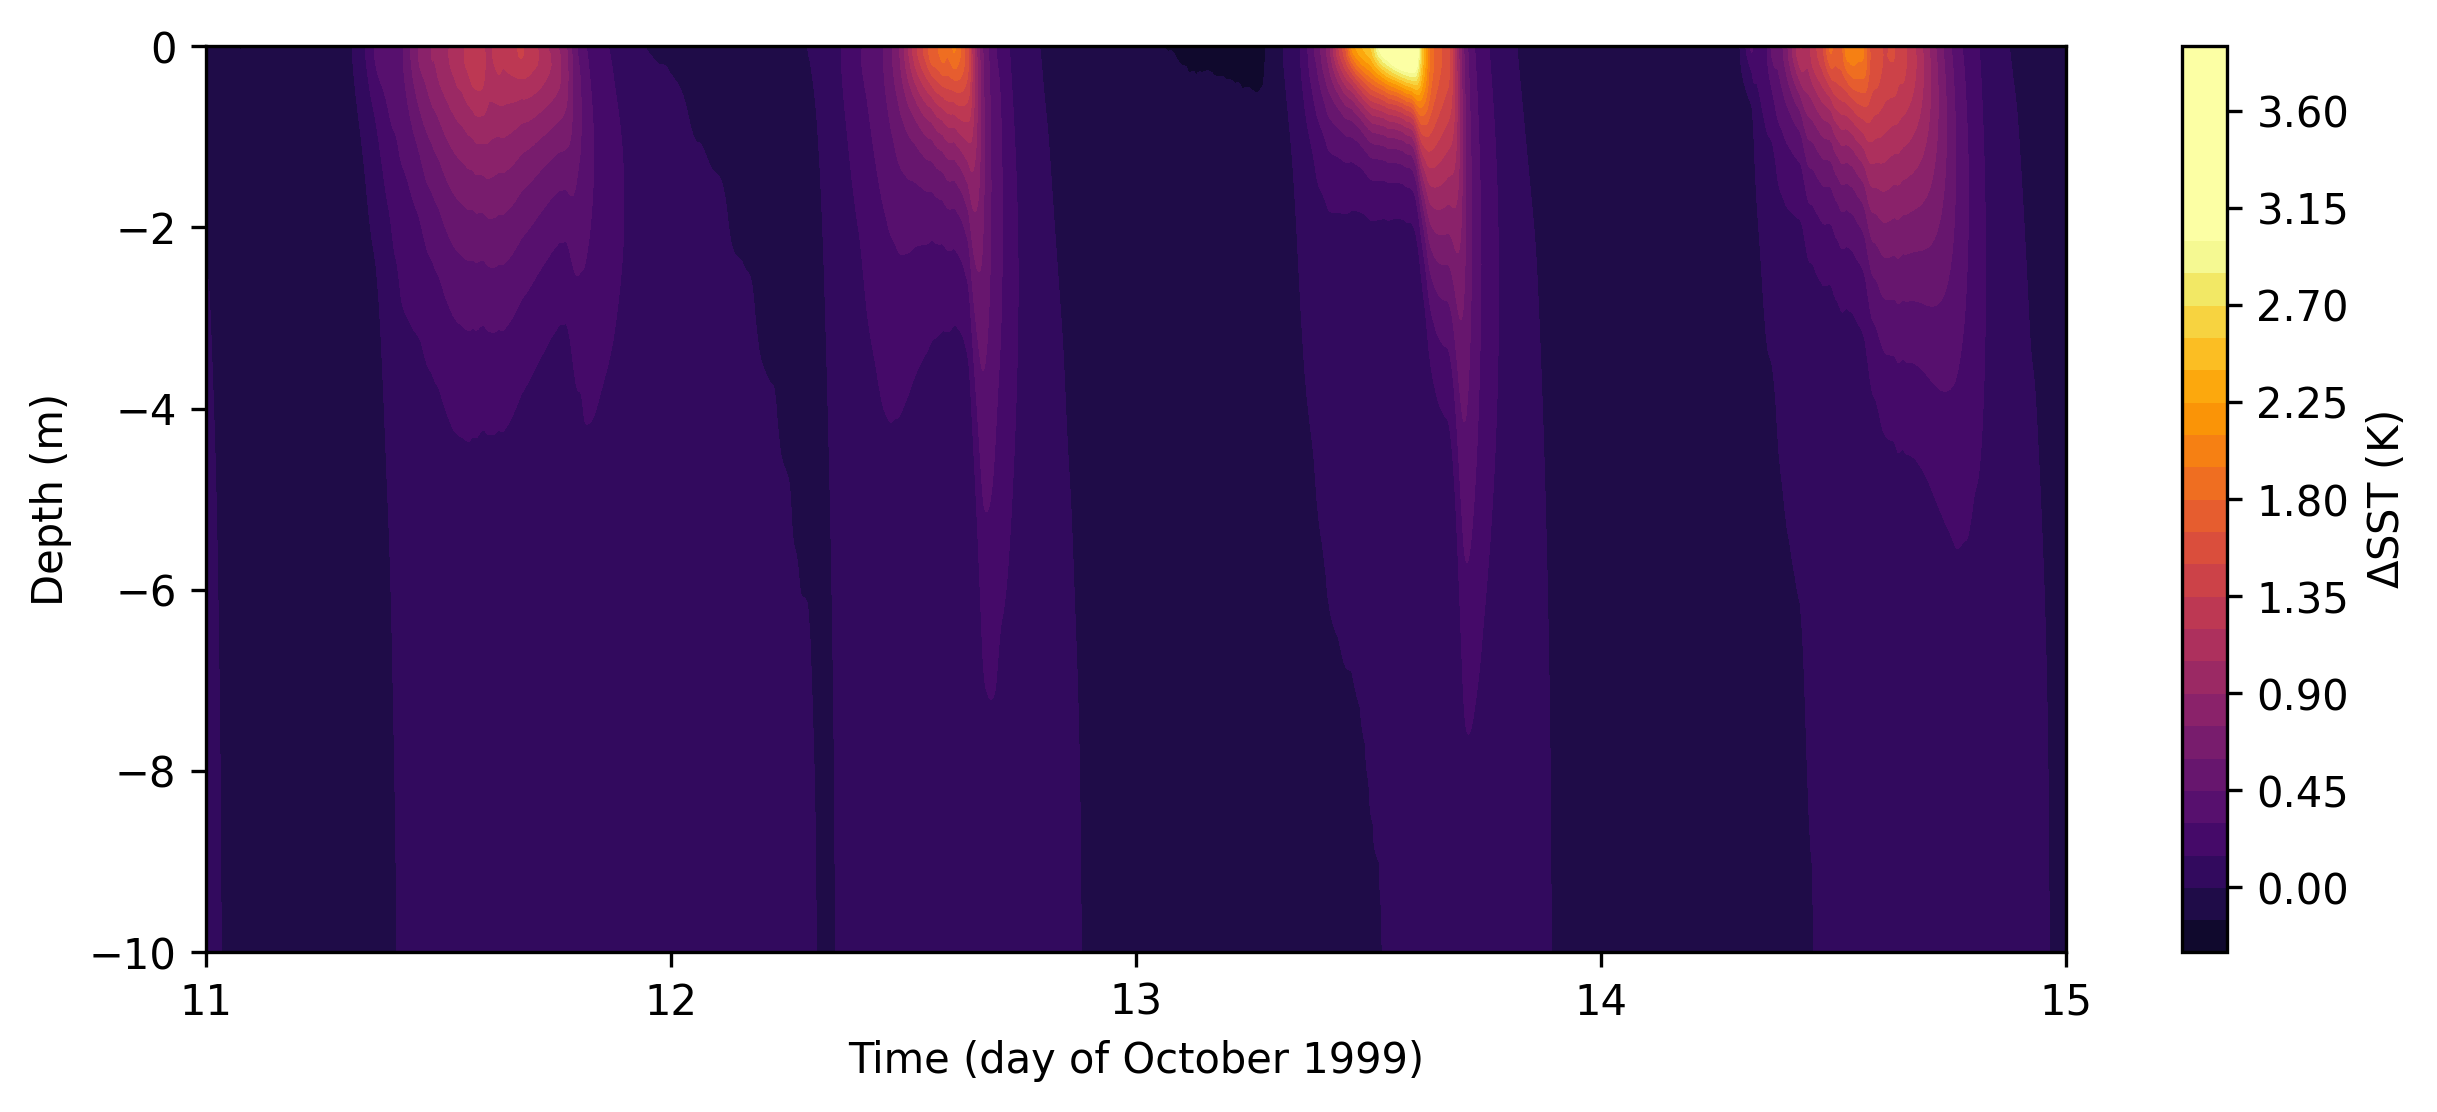

In [15]:
fig, ax = plt.subplots(dpi=300,figsize=(10,4))
plot = ax.contourf(simu[1]/86400,simu[2],simu[0].transpose()-T_f,levels=30,cmap='inferno', vmin=-0.5, vmax=3)

ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax.set(xlabel='Time (day of October 1999)', ylabel='Depth (m)')
ax.set(ylim=(-10,0), xlim=(10,14))
plt.colorbar(plot,label='$\Delta$SST (K)')

plt.show()